<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/PersonalProjects/blob/main/FraudDetection_OnlinePayments/FraudDetection_CreditCard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection: Credit Card

In this file, I will build a fraud detection algorithm for payments via credit cards. Fraud detection algorithms allow us to predict a probability of a given event being fraudulent, given some input parameters, and, thus, understand if more validation is necessary to conduct the transaction. To that end, we will go through the following steps:

1.   Data collection
2.   Data cleaning
3.   Data exploration and analysis
4.   Data modeling and model optimization
5.   Deployment

First, let's download and import the packages which will be used in this project.


In [4]:
# Catboost model

!pip install catboost --quiet

In [5]:
import pandas as pd                                           # Data collection and manipulation
import numpy as np                                            # Work with arrays
import random                                                 # For randomized operations

import matplotlib.pyplot as plt                               # Data visualization
import seaborn as sns                                         # Data visualization
%matplotlib inline

from scipy.stats import normaltest                            # Normality test
from scipy.stats import mannwhitneyu                          # Mann-whitney test

# Modeling

from sklearn.model_selection import train_test_split          # Train-test split

from sklearn.dummy import DummyClassifier                     # Dummy classifier
from sklearn.linear_model import LogisticRegression           # Logistic regression
from sklearn.tree import DecisionTreeClassifier               # Decision tree
from sklearn.ensemble import RandomForestClassifier           # Random forest
from sklearn.ensemble import GradientBoostingClassifier       # Gradient boosting
from xgboost import XGBClassifier                             # XGBoost
from catboost import CatBoostClassifier                       # Catboost

# Model validation

from sklearn import metrics                                   # Metrics for comparing different models
from sklearn.metrics import confusion_matrix                  # Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay            # Confusion matrix plot

# Model deploy

import pickle                                                 # Model serialization
from ipywidgets import widgets, HBox, VBox                    # Interactive simulator
from IPython.display import display                           # Simulator display

So, let's start with the data collection.

# Data collection

In this project, we will use a dataset for credit card payments:

In [6]:
raw_df = pd.read_csv('Dataset_CreditCard_Fraud.csv', sep = ';')

raw_df.columns = ['Distance_home', 'Distance_last_transaction', 'Transaction_value', 'Same_seller', 'Physical_card', 'Password', 'Online', 'Fraud']

In [7]:
raw_df.head( )

,Distance_home,Distance_last_transaction,Transaction_value,Same_seller,Physical_card,Password,Online,Fraud
0,17.801691,1.296368,466.36,1,0,1,1,0
1,5.005299,1.889715,514.60,1,0,0,1,0
2,15.615760,1.126043,837.69,1,1,0,1,0
3,78.065387,0.535579,342.12,1,1,0,1,0
4,35.042909,0.073558,1103.91,1,0,0,1,0


In this dataset, we have information about a given transaction, mainly:

*   Distance_home: The distance from the buyer's home.
*   Distance_last_transaction: The distance from the last transaction.
*   Transaction_value: The transaction value.

Also, we have some boolean features, which state:

*   Same_seller: If the transaction is being performed with the same seller.
*   Physical_card: If the physical card is being used.
*   Password: If the user is inserting the password.
*   Online: If the user is buying something online.

And, of course, the target feature:

*   Fraud: If the transaction is fraudulent.



Note that we have 50,000 entries in our dataset:

In [8]:
raw_df.shape

(50000, 8)

Now, let's start cleaning our data:

# Data cleaning

So, let's clean our dataset. First, let's see if we have any null value:

In [9]:
raw_df.isnull( ).sum( )

Distance_home                0
Distance_last_transaction    0
Transaction_value            0
Same_seller                  0
Physical_card                0
Password                     0
Online                       0
Fraud                        0
dtype: int64

Nice! We have no null value in our dataframe. Now, let's see if we have any duplicated entry:

In [10]:
raw_df.duplicated( ).sum( )

0

Nice! Also, no duplicated entry. 

Now, let's see if we have any strange entry. First, all of our boolean features should only have two possible values: 0 and 1. Let's see if that is the case for all boolean features:

In [11]:
bool_cols = ['Same_seller', 'Physical_card', 'Password', 'Online', 'Fraud']

for bc in bool_cols:
  print('-'*30)
  print(bc)
  print('-'*30)
  for i in range(len(raw_df[bc].unique( ))):
    print('Unique value number ' + str(i + 1) + ' - ' + str(raw_df[bc].unique( )[i]))

------------------------------
Same_seller
------------------------------
Unique value number 1 - 1
Unique value number 2 - 0
------------------------------
Physical_card
------------------------------
Unique value number 1 - 0
Unique value number 2 - 1
------------------------------
Password
------------------------------
Unique value number 1 - 1
Unique value number 2 - 0
------------------------------
Online
------------------------------
Unique value number 1 - 1
Unique value number 2 - 0
------------------------------
Fraud
------------------------------
Unique value number 1 - 0
Unique value number 2 - 1


Nice! All features have only two possible values (0 and 1), as expected. Now, let's see if we have any strange values in our continuous features:

In [12]:
cont_cols = ['Distance_home', 'Distance_last_transaction', 'Transaction_value']

raw_df[cont_cols].describe( )

,Distance_home,Distance_last_transaction,Transaction_value
count,50000.000000,50000.000000,50000.000000
mean,26.732037,5.037710,1838.540043
std,69.287903,21.657879,2836.469831
min,0.038379,0.000338,8.950000
25%,3.897788,0.296896,477.595000
50%,10.061194,0.999128,1002.075000
75%,25.845679,3.326717,2097.670000
max,5797.972589,1400.098234,126294.930000


The mean distance from home is 26.73 km, and the max is 5797.97 km. These values seem to be correct, as one might expect to see these distances. A similar argument can be made regarding the other features. 

Now, let's continue our study by exploring and analyzing our data through some visualization methods.

# Data exploration and analysis

The first thing we are going to do is build a function to draw a countplot with information about the percentage from the total. We can do that using:

In [13]:
def plot_perc(feature, dataset):
  plt.figure(figsize = (16, 6))
  g = sns.countplot(x = feature, data = dataset, orient = 'h')

  g.set_ylabel('Count', fontsize = 18)

  sizes = []
  for p in g.patches:
    height = p.get_height( )
    sizes.append(height)
    g.text(p.get_x( ) + p.get_width( )*0.2, 
           height, 
           '{:1.2f}%'.format(height/len(dataset)*100),
           ha = 'center', va = 'bottom', fontsize = 12)
    
  g.set_ylim(0, max(sizes)*1.1)

Nice! Now, let's compare the number of fraudulent and non-fraudulent data:

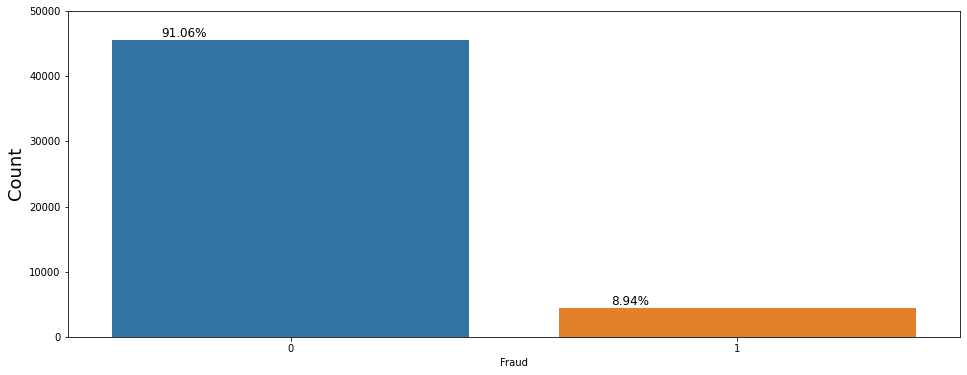

In [14]:
plot_perc('Fraud', raw_df)

So, our fraudulent data corresponds to almost 9% of our dataset. Even though this isn't a very low number, our dataset is still very unbalanced. Now, let's try to understand how is the occurrence of fraud related to the other features. Let's create a new user-defined function:

In [15]:
def plot_perc_compare(feature, feature_hue, dataset):
  plt.figure(figsize = (16, 6))
  g = sns.countplot(x = feature, hue = feature_hue, data = dataset, orient = 'h')

  g.set_ylabel('Count', fontsize = 18)

  sizes = []
  for p in g.patches:
    height = p.get_height( )
    sizes.append(height)
    g.text(p.get_x( ) + p.get_width( )*0.2, 
           height, 
           '{:1.2f}%'.format(height/len(dataset)*100),
           ha = 'center', va = 'bottom', fontsize = 12)
    
  g.set_ylim(0, max(sizes)*1.1)

Now, let's see how many of these frauds come from online transactions:

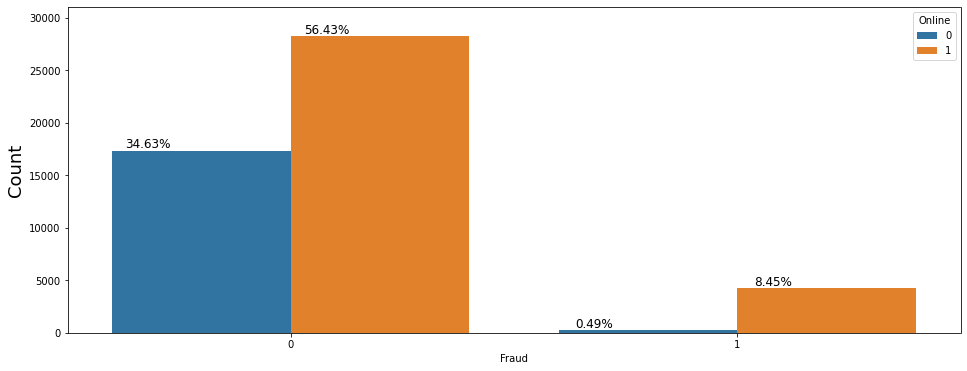

In [16]:
plot_perc_compare('Fraud', 'Online', raw_df)

So, in the non-fraudulent data, the number of online transactions is higher. However, they are fairly close: 34.63% of the transactions are not online, while 56.43% of the transactions are online.

However, when we look at the fraudulent data, we see that almost ALL of the frauds occur in online transactions. 

Nice. We already know that we have to be careful when dealing with online transactions. Now, let's see a similar graph, but know related to the input of a password:

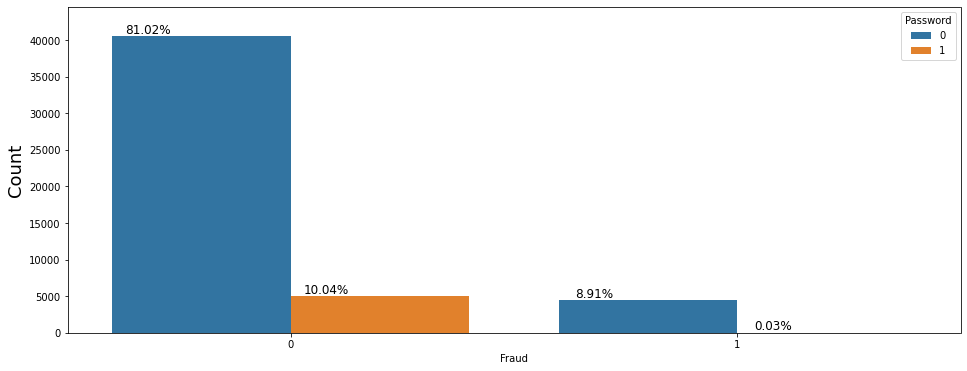

In [17]:
plot_perc_compare('Fraud', 'Password', raw_df)

Here, notice that almost all transactions are performed with using the password. That being said, again, almost ALL fraudulent transactions did not require the password input. Again, that is a very important insight for our company.

Now, let's see how making the transaction using a physical card affects frauds:

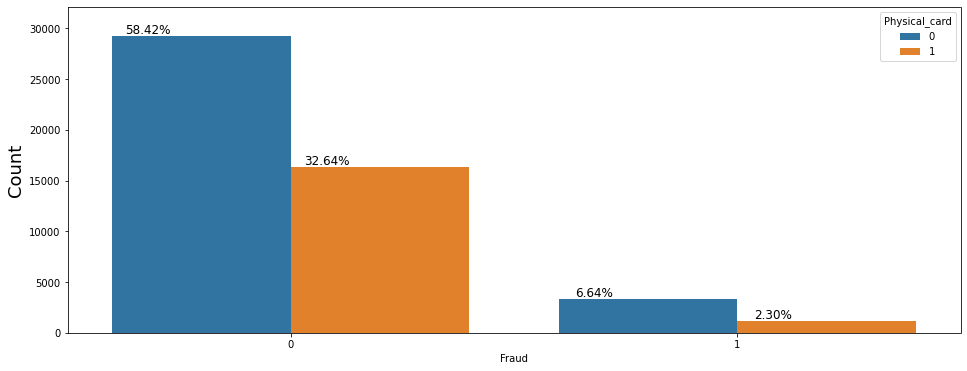

In [18]:
plot_perc_compare('Fraud', 'Physical_card', raw_df)

So, more frauds occur with no physical card. However, a similar ratio is seem in the non-fraudulent data. So, it is hard to say that this feature is very important to us now. 

Finally, let's analyze the final boolean feature, and understand how buying from the same seller affects fraud occurrence:

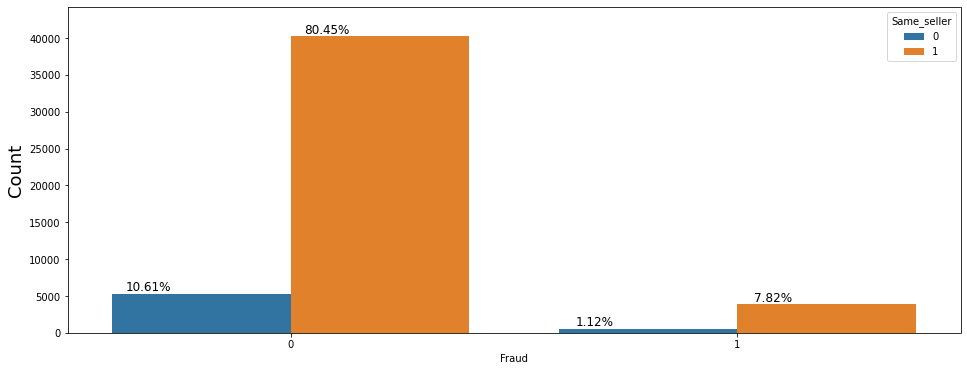

In [19]:
plot_perc_compare('Fraud', 'Same_seller', raw_df)

Again, similar to the previous feature, the distribution for fraudulent and non-fraudulent data is very similar. 

Now, let's look at the continuous features. First, let's draw a boxplot for the transaction value:

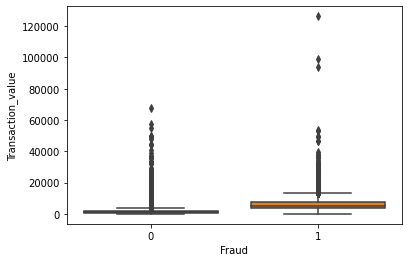

In [20]:
sns.boxplot(x = 'Fraud', y = 'Transaction_value', data = raw_df)

Since data is very right-skewed, it is actually hard to see the comparison. However, we can not that fraudulent transactions often have a higher amount. In fact, all transactions with amount higher than 80000 were fraudulent! That is an important conclusion for us. 

Now, let's see a different feature: the distance to the buyer's home:

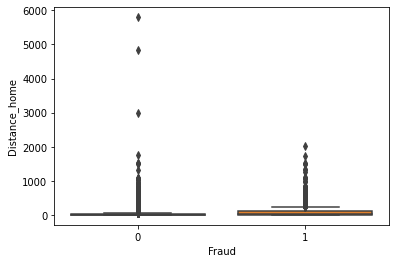

In [21]:
sns.boxplot(x = 'Fraud', y = 'Distance_home', data = raw_df)

This one is a little harder to understand. Let's use a describe to see the values:

In [22]:
group_fraud = raw_df.groupby('Fraud')

group_fraud['Distance_home'].describe( )

,count,mean,std,min,25%,50%,75%,max
Fraud,,,,,,,,
0,45529.0,22.972069,60.516632,0.038379,3.866950,9.780600,24.280399,5797.972589
1,4471.0,65.020471,121.605785,0.067886,4.520484,15.068831,101.380199,2033.498174


So, by looking at the mean, it seems that fraudulent transactions have a higher distance from home. However, note that we have some very far transactions that are not fraudulent! A very similar thing occurs when we analyze the distance from the previous transaction:

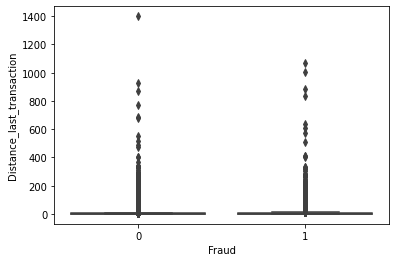

In [23]:
sns.boxplot(x = 'Fraud', y = 'Distance_last_transaction', data = raw_df)

In [24]:
group_fraud['Distance_last_transaction'].describe( )

,count,mean,std,min,25%,50%,75%,max
Fraud,,,,,,,,
0,45529.0,4.288774,17.142865,0.000338,0.292787,0.981444,3.238316,1400.098234
1,4471.0,12.664263,46.793033,0.001733,0.347318,1.198794,4.391936,1070.617532


To be more sure, here, we can use a Mann-Whitney test. In this test, we check if the data has the same distribution. It is usually used as a non-parametric test for the comparison between means of two datasets. So, we can do:

In [25]:
df_frauds   = raw_df.query('Fraud == 1')
df_nofrauds = raw_df.query('Fraud == 0')

So, we will test if:

\begin{equation}
H_0 : \text{Group 1 does not present lower values ($\mu_1 \geq \mu_2$).}
\end{equation}

\begin{equation}
H_1 : \text{Group 1 usually presents lower values ($\mu_1 <\mu_2$).}
\end{equation}

where subscript $1$ refers to the non-fraudulent data and $2$ to the fraudulent data.

In [26]:
mannwhitneyu(df_nofrauds.Transaction_value, df_frauds.Transaction_value, alternative = 'less')

MannwhitneyuResult(statistic=30455479.0, pvalue=0.0)

So, since the $p$-value is 0, we can say that, indeed, transaction values are higher in the fraud set. Now, let's test the same thing for the other features:

In [27]:
mannwhitneyu(df_nofrauds.Distance_home, df_frauds.Distance_home, alternative = 'less')

MannwhitneyuResult(statistic=82938441.0, pvalue=2.52395664173379e-93)

In [28]:
mannwhitneyu(df_nofrauds.Distance_last_transaction, df_frauds.Distance_last_transaction, alternative = 'less')

MannwhitneyuResult(statistic=94037640.0, pvalue=2.1060608309234386e-17)

Again, both of our $p$-values were very low! So, we can say that distances are higher for the fraudulent set.

Finally, let's see the histogram from each of our continuous features:

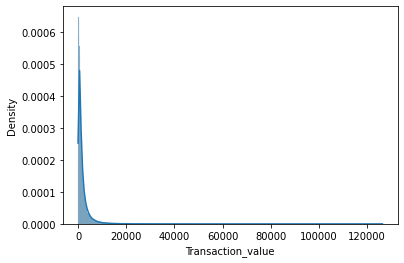

In [29]:
sns.histplot(x = 'Transaction_value', data = raw_df, stat = 'density', kde = 'True')

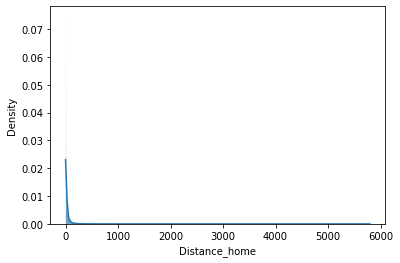

In [30]:
sns.histplot(x = 'Distance_home', data = raw_df, stat = 'density', kde = 'True')

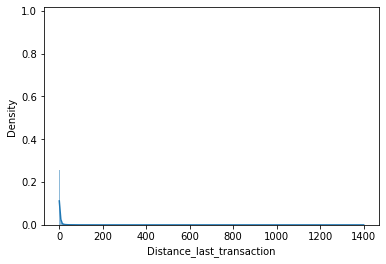

In [31]:
sns.histplot(x = 'Distance_last_transaction', data = raw_df, stat = 'density', kde = 'True')

Note that our data is **VERY** right skewed. To make it easier for our model to handle the data, we could make a transformation by taking the log of each variable:

In [32]:
df = raw_df.copy( )
df['Transaction_value']         = np.log(df['Transaction_value'])
df['Distance_home']             = np.log(df['Distance_home'])
df['Distance_last_transaction'] = np.log(df['Distance_last_transaction'])

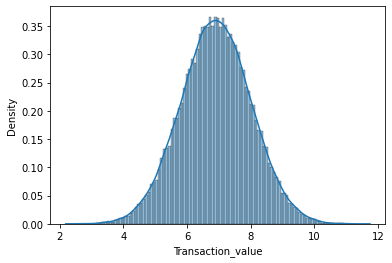

In [33]:
sns.histplot(x = 'Transaction_value', data = df, stat = 'density', kde = 'True')

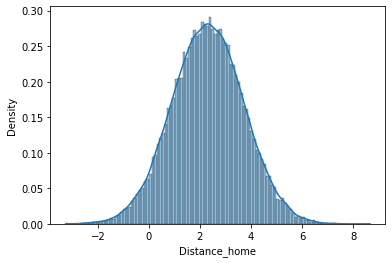

In [34]:
sns.histplot(x = 'Distance_home', data = df, stat = 'density', kde = 'True')

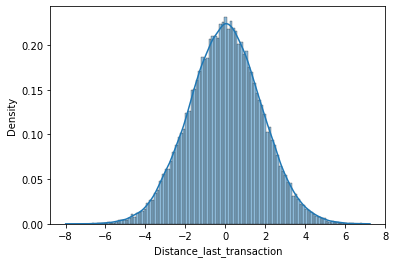

In [35]:
sns.histplot(x = 'Distance_last_transaction', data = df, stat = 'density', kde = 'True')

Nice! Now, our feature distribution looks a lot like a normal curve! We can even use a normality test to check it:



\begin{equation}
H_0 : \text{Data distribution is close to a Normal.}
\end{equation}

\begin{equation}
H_1 : \text{Data does not come from a Normal.}
\end{equation}

In [36]:
normaltest(df['Transaction_value'])

NormaltestResult(statistic=1.4897330797393598, pvalue=0.47479766226952813)

In [37]:
normaltest(df['Distance_home'])

NormaltestResult(statistic=0.5177288941078586, pvalue=0.7719276530196129)

In [38]:
normaltest(df['Distance_last_transaction'])

NormaltestResult(statistic=3.694239816010186, pvalue=0.1576906765797867)

Nice! Now, all of our features "passed" the normality test! Now, it we be much easier to model our data.

Now, let's plot a scatter plot between two features, and see how this scatter plot relates to the occurrence of fraud. Since we have three continuous features, we will plot three scatter plots (3 pairs of parameters):

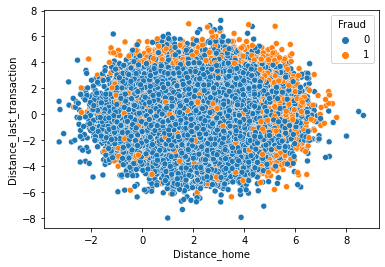

In [39]:
sns.scatterplot(x = 'Distance_home', y = 'Distance_last_transaction', hue = 'Fraud', data = df)

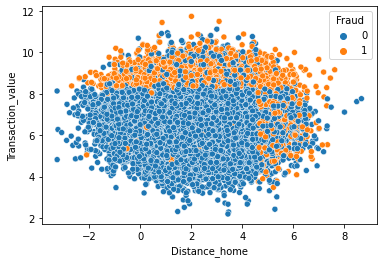

In [40]:
sns.scatterplot(x = 'Distance_home', y = 'Transaction_value', hue = 'Fraud', data = df)

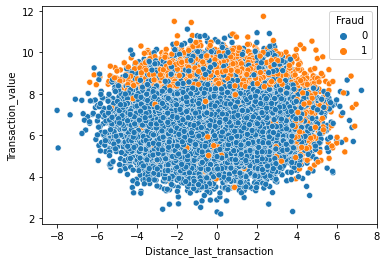

In [41]:
sns.scatterplot(x = 'Distance_last_transaction', y = 'Transaction_value', hue = 'Fraud', data = df)

Notice that, in fact, when we have higher values and distances, our frauds become more evident. However, not all transactions with high values/distances are fraudulent. Our challenge is to correctly define a model to identify this trend, and be able to differ these entries!

Now, let's check the correlation between our features:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


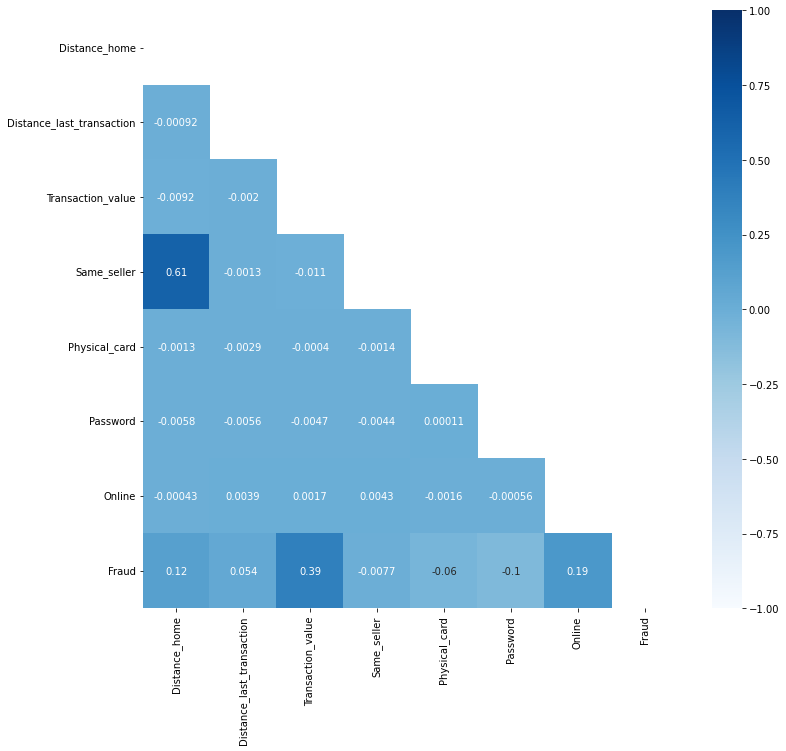

In [42]:
plt.figure(figsize=(12, 11))

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Blues')

The correlation between our data seem very low. Most of our independent features have a very low correlation (which is actually good). However, our target feature also seems to have a low correlation with most other features. The correlation is higher only between transaction value and the online boolean feature. 

Now that we understood our data, let's go to data modeling.

# Data modeling

So, let's model our data to detect when frauds will occur. Let's start by splitting our dataset:

In [43]:
X = df.drop('Fraud', axis = 1)   # Independent variables
y = df.Fraud                     # Target variable

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

Now, we will start using very simple models: first a dummy classifier, and then a simple logistic regression. Then, we will test more complex models, and see if they are able to improve upon our results.

## Dummy classifier

First, we will use a very simple dummy classifier, where our model always picks the most frequent class. Thus, we can do:

In [44]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

Then, we can get the prediction on the text set using:

In [45]:
y_pred = dummy_clf.predict(X_test)

Now, let's evaluate some metrics for our model. For classification models, there are some very important metrics, usually related to the True Positives ($TP$), True Negatives ($TN$), False Positives ($FP$), and False Negatives ($FN$). These are:

* Accuracy: The accuracy evaluates the division between correctly guessed entries, and the total number of entries.

\begin{equation}
\dfrac{TN + TP}{TN + TP + FN + FP}
\end{equation}

* Precision: Precision evaluates the proportion of $TP$ in relation to the positive predictions from the model. If we have low precision, it means that there are a lot of non-frauds that our model is identifying as frauds.

\begin{equation}
\dfrac{TP}{TP + FP}
\end{equation}

* Recall: Recall evaluates the proportion of $TP$ and the number of positives from the test set. If we have a lower recall, it means that we are letting many frauds pass.

\begin{equation}
\dfrac{TP}{TP + FN}
\end{equation}

* F1-score: Tries to balance precision and recall. It goes from 0 to 1, and the closest it is to 1, the better.

\begin{equation}
2 \, \dfrac{P \, R}{P + R}
\end{equation}

The number of true positives and negatives, and false positives and negatives can be taken from the confusion matrix:

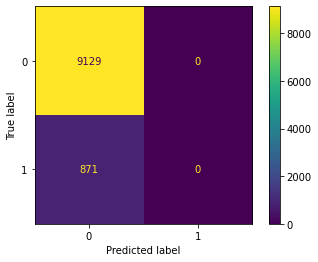

In [46]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format='d')

Since our dummy classifier only guesses for the most frequent class, it thinks that none of our data is fraudulent. Thus, we have 9129 true negatives and 871 false negatives. Let's get the metrics for this case:

In [47]:
acc = round(metrics.accuracy_score(y_test, y_pred), 4)
prc = round(metrics.precision_score(y_test, y_pred), 4)
rec = round(metrics.recall_score(y_test, y_pred), 4)
f1s = round(metrics.f1_score(y_test, y_pred), 4)

print(f"Accuracy  : {acc}")
print(f"Precision : {prc}")
print(f"Recall    : {rec}")
print(f"F1        : {f1s}")

Accuracy  : 0.9129
Precision : 0.0
Recall    : 0.0
F1        : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note that, while our dummy classifier showed a precision of 91.29%, it showed a 0.00% precision and recall. That happened because our model has **no** true positives, and was not able to detect any fraudulent transaction. Thus, in fact, the dummy classifier is a very bad fraud detection method, and the accuracy is not a good metric to evaluate the model when our data is very unbalanced.

To finish things off, let's plot the precision-recall curve for the dummy classifier:

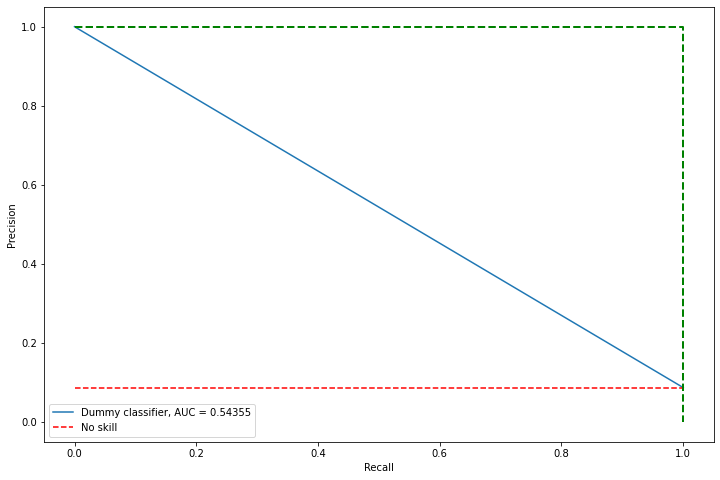

In [48]:
y_pred_proba = dummy_clf.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'Dummy classifier, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'No skill')
plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

The precision-recall curve shows that our model is very poor, showing an Area Under the Curve (AUC) of 0.54355, and being very far from the perfect model. 

Now, let's add these precision metrics into a dataframe and let's move to the next model:

In [49]:
df_metrics = pd.DataFrame( {'acc' : acc, 'prc' : prc, 'rec' : rec, 'f1s' : f1s, 'auc' : auc }, index = ['Dummy classifier'] )
df_metrics

,acc,prc,rec,f1s,auc
Dummy classifier,0.9129,0.0,0.0,0.0,0.54355


## Logistic Regression

Now, let's try another simple, yet much more powerful, model: the logistic regression. Since our dataset is very unbalanced, we may use the ```class_weigth``` parameter. We will make it so that the weight for each fraud data is equal to:

\begin{equation}
w = \dfrac{n_0}{n_1}
\end{equation}

where $n_0$ is the number of samples from class 0 (non-frauds) and $n_1$ is the number of samples from class 1 (frauds). Thus, we can do:

In [50]:
n_0 = y_train[y_train == 0].shape[0]
n_1 = y_train[y_train == 1].shape[0]
w = n_0/n_1

print(f'w = {round(w, 2)}')

w = 10.11


Thus, we will give a weight of 10.11 for each fraudulent data. Thus, we can fit the Logistic Regression model using:

In [51]:
model_LogReg = LogisticRegression(class_weight = {0 : 1, 1 : w}, random_state = SEED)

model_LogReg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 10.11111111111111}, random_state=42)

Now, let's get the prediction in the test sample and get the confusion matrix for our new model:

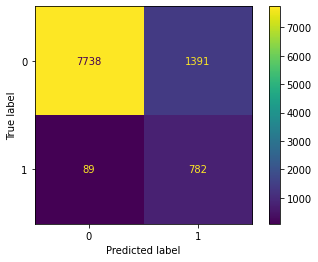

In [52]:
y_pred = model_LogReg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format = 'd')

Now, we got 7738 True Negatives, 782 True Positives, 1391 False Positives, and 89 False Negatives. Let's evaluate our metrics:

In [53]:
acc = round(metrics.accuracy_score(y_test, y_pred), 4)
prc = round(metrics.precision_score(y_test, y_pred), 4)
rec = round(metrics.recall_score(y_test, y_pred), 4)
f1s = round(metrics.f1_score(y_test, y_pred), 4)

print(f"Accuracy  : {acc}")
print(f"Precision : {prc}")
print(f"Recall    : {rec}")
print(f"F1        : {f1s}")

Accuracy  : 0.852
Precision : 0.3599
Recall    : 0.8978
F1        : 0.5138


Now, using a very simple model, we managed to achieve a recall of 89.78%. That means that we were able to detect 89.78% of the fraudulent transactions in our test set. That's very good. However, notice that our accuracy lowered. Since accuracy is not as important for problems with a very unbalanced dataset, this is ok. However, our precision is also not very high still. 

When we use class weight, our model may end up "thinking" that our prioritized class is much more frequent in the dataset. Then, it may end up having a lot of false positives. In fact, we have more false positives than true positives in our model.

At the same time, from the 9129 non-fraudulent entries, only 1391 were predicted to be frauds (15.23%). Also, since it is very important for our company to predict fraudulent transactions (due to the high value involved in these), it means that recall is far more important than precision (even though both are important to evaluate a given fraud detection model).

We can understand more about the trade-off between precision and recall by the precision-recall curve:

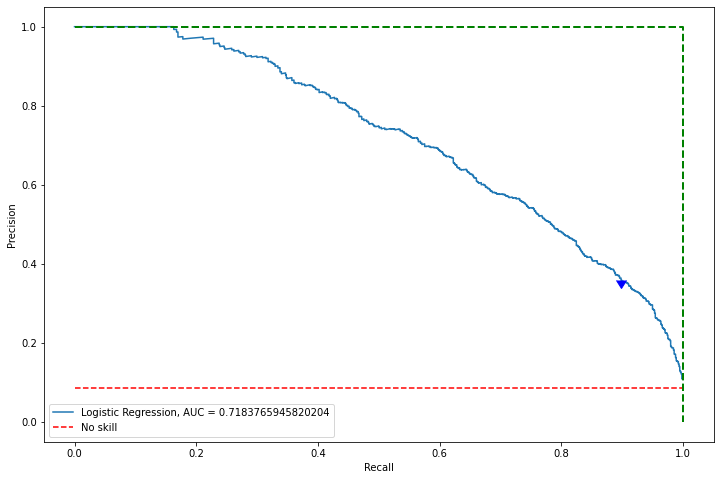

In [54]:
y_pred_proba = model_LogReg.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'Logistic Regression, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'No skill')

plt.plot(rec, prc, 'b', marker = 11, markersize = 10)

plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

The precision-recall curve shows different pairs precision-recall for different probability thresholds. The point evaluated before is shown as a blue triangle, which corresponds to the default threshold (0.5). Note that we can actually change the threshold to "optimize" recall and precision. However, there is a trade-off here: when we increase precision, we often reduce recall, and when we increase recall, we often reduce precision. 

In this project, we will attempt to optimize our threshold by maximizing recall. However, we will require that our model has at least a precision of 50%, which means that, from the predicted frauds, at least 50% are real frauds. 

For that end, we will define a new metric, where:

\begin{equation}
M_{PR} = R \text{, if $P \geq P_t$}
\end{equation}

\begin{equation}
M_{PR} = 0 \text{, otherwise}
\end{equation}

where, in this project, $P_t = 0.5$. Thus, we can do:

In [55]:
Pt = 0.5

In [56]:
def calc_MPR(R, P, Pt):
  return R if (P >= Pt) else 0

In [57]:
def calc_MPR_list(Rlist, Plist, Pt):
  return [calc_MPR(Rlist[i], Plist[i], Pt) for i in range(len(Rlist))]

In [58]:
def calc_opt_threshold(Tlist, Mlist, Plist):
  max_index = np.where(Mlist == np.amax(Mlist))

  if isinstance(max_index, tuple):                            # This condition serves to check if there are multiple entries with the same 
     Plist_tmp = Plist[max_index]                             #  M_{PR} and, if so, it gets the entry with the higher precision.
     max_ind_prc = np.where(Plist_tmp == np.amax(Plist_tmp))                                  
     max_index = max_index[0][max_ind_prc]

  return (Tlist[max_index][0], np.amax(Mlist))

Nice! Now, let's get the optimal threshold for our Logistic Regression model:

In [59]:
mprr = calc_MPR_list(recr, prcr, Pt)

In [60]:
opt_thresh, opt_mpr = calc_opt_threshold(threshold, mprr, prcr)

print(f'The optimum threshold is {round(opt_thresh, 2)} (guarantees a precision of 50%).')

The optimum threshold is 0.72 (guarantees a precision of 50%).


Nice! Now, let's try to get the confusion matrix for this threshold. First, let's define a function to predict the classes for a given threshold:

In [61]:
def pred_threshold(model, X, t):
  y_prob = model.predict_proba(X)[::, 1]
  y_pred = []
  for i in range(len(y_prob)):
    y_pred.append(0 if (y_prob[i] < t) else 1)

  return (y_pred, y_prob)

Now, let's get the confusion matrix:

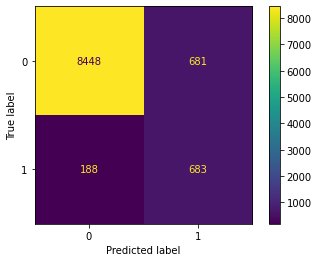

In [62]:
(y_pred_t, y_prob) = pred_threshold(model_LogReg, X_test, opt_thresh)

cm = confusion_matrix(y_test, y_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format = 'd')

And let's evaluate our metrics:

In [63]:
acc = round(metrics.accuracy_score(y_test, y_pred_t), 4)
prc = round(metrics.precision_score(y_test, y_pred_t), 4)
rec = round(metrics.recall_score(y_test, y_pred_t), 4)
f1s = round(metrics.f1_score(y_test, y_pred_t), 4)

print(f"Accuracy  : {acc}")
print(f"Precision : {prc}")
print(f"Recall    : {rec}")
print(f"F1        : {f1s}")

Accuracy  : 0.9131
Precision : 0.5007
Recall    : 0.7842
F1        : 0.6112


Now, our accuracy and precision increased (when compared to the first logistic regression confusion matrix). This time, we can consider that, at least, half the frauds our model is predicting are, indeed, frauds. However, at the same time, the recall decreased. That is expected: since we increased our threshold (from 0.50 to 0.72), our model we detect less frauds. 

Nice! Now, we have defined a minimum precision for our model, and a way to optimize our prediction probability threshold (in a way that we maximize recall and guarantee at least a 50% precision). Let's add this information to the dataframe:

In [64]:
df_metrics.loc['Dummy classifier', 'mpr']       = df_metrics.loc['Dummy classifier', 'rec']
df_metrics.loc['Dummy classifier', 'threshold'] = 0.50

In [65]:
df_metrics.loc['Logistic Regression'] = [acc, prc, rec, f1s, auc, opt_mpr, opt_thresh]

In [66]:
df_metrics

,acc,prc,rec,f1s,auc,mpr,threshold
Dummy classifier,0.9129,0.0000,0.0000,0.0000,0.543550,0.000000,0.500000
Logistic Regression,0.9131,0.5007,0.7842,0.6112,0.718377,0.784156,0.715873


Now, let's try to fit other models, and see if we can improve upon our logistic regression.

## Testing out more robust models

This time, we will try to use other modeling criteria, namely:

*   Decision tree
*   Random forest
*   Gradient boosting
*   Catboost
*   XGBoost

Also, we will try to optimize the $M_{PR}$ for these models, trying to guarantee a minimum precision of 50%. First, let's define a user-defined function to get the metrics that we need:



In [67]:
def GetMetrics(model, X_test, y_test):
  y_pred_proba = model.predict_proba(X_test)[::, 1]
  prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
  auc = metrics.auc(recr, prcr)

  mprr = calc_MPR_list(recr, prcr, Pt)
  opt_thresh, opt_mpr = calc_opt_threshold(threshold, mprr, prcr)
  y_pred_t, y_pred_proba = pred_threshold(model, X_test, opt_thresh)

  acc = round(metrics.accuracy_score(y_test, y_pred_t), 4)
  prc = round(metrics.precision_score(y_test, y_pred_t), 4)
  rec = round(metrics.recall_score(y_test, y_pred_t), 4)
  f1s = round(metrics.f1_score(y_test, y_pred_t), 4)

  return [acc, prc, rec, f1s, auc, opt_mpr, opt_thresh]

Now, let's instance our models:

In [68]:
model_DcTree = DecisionTreeClassifier(class_weight = {0 : 1, 1 : w}, max_depth = 5, random_state = SEED)
model_RndFor = RandomForestClassifier(class_weight = {0 : 1, 1 : w}, max_depth = 5, random_state = SEED)
model_GrdBst = GradientBoostingClassifier(random_state = SEED)
model_CatBst = CatBoostClassifier(class_weights = [1, w], verbose = False, random_state = SEED)
model_XtGBst = XGBClassifier(class_weight = {0 : 1, 1 : w}, seed = SEED)

models = [model_DcTree, model_RndFor, model_GrdBst, model_CatBst, model_XtGBst]

Note that the Gradient Boosting Classifier has no class weight. Due to how the model works, it actually does not need to correct class imbalance via this parameter.

https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7

Now, to fit our models and get the metrics and optimal threshold, we can do:

In [69]:
for model in models:

  print('-'*30)
  print('Model ' + model.__class__.__name__)
  print('-'*30)

  print('Training...')
  model.fit(X_train, y_train)

  print('Evaluating metrics...')
  df_metrics.loc[model.__class__.__name__] = GetMetrics(model, X_test, y_test)

  print('Done.')

------------------------------
Model DecisionTreeClassifier
------------------------------
Training...
Evaluating metrics...
Done.
------------------------------
Model RandomForestClassifier
------------------------------
Training...
Evaluating metrics...
Done.
------------------------------
Model GradientBoostingClassifier
------------------------------
Training...
Evaluating metrics...
Done.
------------------------------
Model CatBoostClassifier
------------------------------
Training...
Evaluating metrics...
Done.
------------------------------
Model XGBClassifier
------------------------------
Training...
Evaluating metrics...
Done.


Nice! Now, let's see the metrics for each model:

In [70]:
df_metrics.sort_values(by = ['mpr', 'prc'], ascending = [False, False])

,acc,prc,rec,f1s,auc,mpr,threshold
CatBoostClassifier,0.9987,0.9853,1.0000,0.9926,0.999740,1.000000,0.827503
RandomForestClassifier,0.9850,0.8531,1.0000,0.9207,0.999723,1.000000,0.358197
XGBClassifier,0.9361,0.5768,1.0000,0.7316,0.999374,1.000000,0.007901
GradientBoostingClassifier,0.9983,0.9819,0.9989,0.9903,0.999376,0.998852,0.351154
DecisionTreeClassifier,0.9953,0.9498,0.9989,0.9737,0.999048,0.998852,0.612382
Logistic Regression,0.9131,0.5007,0.7842,0.6112,0.718377,0.784156,0.715873
Dummy classifier,0.9129,0.0000,0.0000,0.0000,0.543550,0.000000,0.500000


Nice! Our Catboost classifier managed to get a 100% recall, while also achieving a precision of 98.53%! That's really good! Notice that optimization of the threshold was very important for our model, as the optimal threshold was 0.8275 (very different from the default 0.50).

So, let's fit our model once again, and let's take a look at the confusion matrix and to the precision-recall curve:

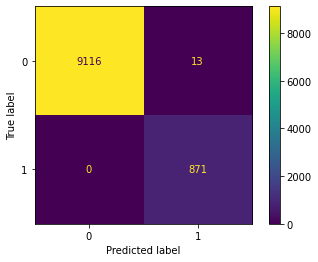

In [71]:
opt_thresh = df_metrics.loc[model_CatBst.__class__.__name__, 'threshold']

model_CatBst.fit(X_train, y_train)
y_pred_t, y_pred_proba = pred_threshold(model_CatBst, X_test, opt_thresh)

cm = confusion_matrix(y_test, y_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format = 'd')

So, using Catboost, we have 9116 True Negatives, 871 True Positives, 13 False Positives and 0 False Negatives! We managed to detect ALL frauds from the test set, and, from the non-fraudulent set, only 0.14% were incorrectly guessed as frauds.

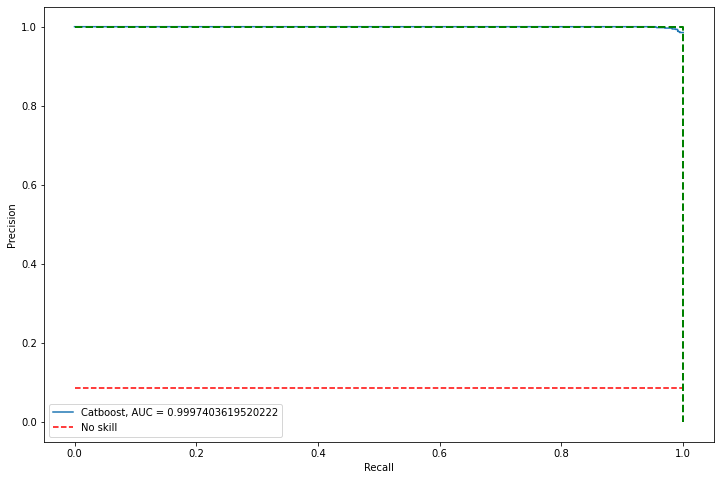

In [72]:
y_pred_proba = model_CatBst.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'Catboost, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'No skill')

plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

So, our Catboost model is **VERY** close to the perfect model. That's very good for us.

## Model optimization

So, our Catboost model actually showed an outstanding result for our data. However, maybe we are able to improve it even more. For that end, let's test different parameters through a randomized grid.

First, let's define the parameter grid:

In [73]:
learning_rate  = [0.01, 0.1, 0.3, 0.5, 1]                      # Learning rate
max_depth      = [3, 6, 9, 12]                                 # Max depth of each tree  
l2_leaf_reg    = [0.1, 1.0, 3.0, 10.0, 50.0]                   # Regularization term (L2 norm) 
n_estimators   = [100, 500, 1000, 5000]                        # Number of estimators  
loss_function  = ['Logloss', 'CrossEntropy']                   # Loss function metric used for training
bootstrap_type = ['Bayesian', 'Bernoulli', 'MVS']              # Method for sampling the weights of objects  

These are just some of the possible Catboost parameters. We can find more in:

https://catboost.ai/en/docs/references/training-parameters/

Now, we will build $n = 20$ models using parameters from the grid (picked at random). Then, we will evaluate the metrics for each of those models.

In [74]:
n_models = 20

results_df = pd.DataFrame(columns = ['learning_rate', 'max_depth', 'l2_leaf_reg', 'n_estimators', 'loss_function', 'bootstrap_type', 'dict', 
                                     'acc', 'prc', 'rec', 'f1s', 'auc', 'mrp', 'threshold'])

model_list  = []

for i in range(n_models):
  lr    = random.choice(learning_rate)
  md    = random.choice(max_depth)
  l     = random.choice(l2_leaf_reg)
  n_est = random.choice(n_estimators)
  lf    = random.choice(loss_function)
  btype = random.choice(bootstrap_type)
  params_dict = {'learning_rate' : lr, 'max_depth' : md, 'l2_leaf_reg' : l, 'n_estimators' : n_est, 'loss_function' : lf, 'bootstrap_type' : btype}
  params_list = [lr, md, l, n_est, lf, btype, params_dict]

  cat = CatBoostClassifier(**params_dict, verbose = False, random_state = SEED)

  print('-'*30)
  print('Model ' + cat.__class__.__name__ + ' ' + str(i + 1))
  print('-'*30)

  print('Training...')
  cat.fit(X_train, y_train)

  print('Evaluating metrics...')
  cat_metrics = GetMetrics(cat, X_test, y_test)

  print('Saving...')
  results_df.loc[i] = [*params_list, *cat_metrics]

  print('Done.')

------------------------------
Model CatBoostClassifier 1
------------------------------
Training...
Evaluating metrics...
Saving...
Done.
------------------------------
Model CatBoostClassifier 2
------------------------------
Training...
Evaluating metrics...
Saving...
Done.
------------------------------
Model CatBoostClassifier 3
------------------------------
Training...
Evaluating metrics...
Saving...
Done.
------------------------------
Model CatBoostClassifier 4
------------------------------
Training...
Evaluating metrics...
Saving...
Done.
------------------------------
Model CatBoostClassifier 5
------------------------------
Training...
Evaluating metrics...
Saving...
Done.
------------------------------
Model CatBoostClassifier 6
------------------------------
Training...
Evaluating metrics...
Saving...
Done.
------------------------------
Model CatBoostClassifier 7
------------------------------
Training...
Evaluating metrics...
Saving...
Done.
---------------------------

In [75]:
results_df.sort_values(by = ['mrp', 'prc'], ascending = [False, False]).head(1)

,learning_rate,max_depth,l2_leaf_reg,n_estimators,loss_function,bootstrap_type,dict,acc,prc,rec,f1s,auc,mrp,threshold
2,0.1,12,0.1,500,CrossEntropy,Bernoulli,"{'learning_rate': 0.1, 'max_depth': 12, 'l2_le...",0.999,0.9886,1.0,0.9943,0.99969,1.0,0.155671


So, in our best model, we actually managed to find a precision *slightly* better than the default model: 98.86%. Well, let's train it again, and take a look at the confusion matrix:

In [76]:
best_index = results_df.sort_values(by = ['mrp', 'prc'], ascending = [False, False]).index[0]
model_params = results_df.loc[best_index, 'dict']
opt_thresh   = results_df.loc[best_index, 'threshold']

model_CatBst_opt = CatBoostClassifier(**model_params, verbose = False, random_state = SEED)
model_CatBst_opt.fit(X_train, y_train)

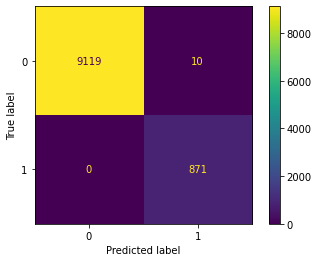

In [77]:
y_pred_t, y_pred_proba = pred_threshold(model_CatBst_opt, X_test, opt_thresh)

cm = confusion_matrix(y_test, y_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(values_format = 'd')

So, basically, the difference from this model to the previous one is that this has only 10 False Positives instead of 13. Not a big difference, but an improvement after all. The precision-recall curve is also very similar from the previous curve:

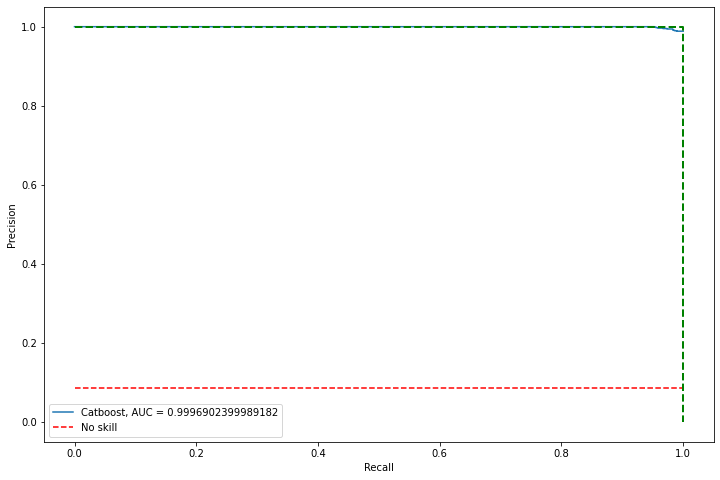

In [78]:
y_pred_proba = model_CatBst_opt.predict_proba(X_test)[::, 1]
prcr, recr, threshold = metrics.precision_recall_curve(y_test, y_pred_proba)
auc = metrics.auc(recr, prcr)

no_skill = y_test[y_test == 1].shape[0] / y_test.shape[0]

fig = plt.figure(figsize = (12, 8))

plt.plot(recr, prcr, label = 'Catboost, AUC = '+str(auc))
plt.plot([0, 1], [no_skill, no_skill], color = 'r', linestyle='--', label = 'No skill')

plt.legend(loc = 'best')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.plot([0, 1, 1], [1, 1, 0], color = 'g', lw = 2, linestyle = '--', label = 'Perfect model')

# Deployment

After defining a optimum model, we can deploy it. First, let's use pickle to serialize it, so we can save it in a file:

In [104]:
output = open('FraudDetect_CreditCard_OptCatBoost.sav', 'wb')
pickle.dump( model_CatBst_opt, output )
output.close( )

Thus, if we want to use the model in other application, we don't have to train it again. We can simply do:

In [105]:
serialized_model = open('FraudDetect_CreditCard_OptCatBoost.sav', 'rb')
CatBst_model = pickle.load(serialized_model)
serialized_model.close( )

Nice! Now, to finish things up, let's just build an interactive simulator, so that one may "play" with our new model:

In [106]:
distance_home   = widgets.FloatText(description = 'Dist. home (km): ')
distance_last   = widgets.FloatText(description = 'Dist. last (km): ')
transaction_val = widgets.FloatText(description = 'Value: ')
same_seller     = widgets.RadioButtons(description = 'Same seller?', options = ['No', 'Yes'])
physical        = widgets.RadioButtons(description = 'Physical card?', options = ['No', 'Yes'])
password        = widgets.RadioButtons(description = 'Password?', options = ['No', 'Yes'])
online          = widgets.RadioButtons(description = 'On-line?', options = ['No', 'Yes'])

button = widgets.Button(description = 'Detect')

left  = VBox([distance_home, distance_last, transaction_val])
med   = VBox([same_seller, physical])
right = VBox([password, online])
inputs = HBox([left, med, right])

In [107]:
def detect(sender):
  d_home = np.log(float(distance_home.value))
  d_last = np.log(float(distance_last.value))
  value  = np.log(float(transaction_val.value))

  same_str = str(same_seller.value)
  phys_str = str(physical.value)
  pswd_str = str(password.value)
  onln_str = str(online.value)

  same = 1 if (same_str == 'Yes') else 0
  phys = 1 if (phys_str == 'Yes') else 0
  pswd = 1 if (pswd_str == 'Yes') else 0
  onln = 1 if (onln_str == 'Yes') else 0

  X_v = pd.DataFrame( {'Distance_home' : d_home, 'Distance_last_transaction' : d_last, 'Transaction_value' : value,
                       'Same_seller' : same, 'Physical_card' : phys, 'Password' : pswd, 'Online' : onln}, index = [0] )
  
  y_pred, y_prob = pred_threshold(CatBst_model, X_v, opt_thresh)

  if y_pred == 0:
    print(f'Transaction is not fraudulent (Probability of {round(y_prob[0]*100, 2)}%, threshold of {round(opt_thresh*100, 2)}%).')
  else:
    print(f'Transaction is fraudulent (Probability of {round(y_prob[0]*100, 2)}%, threshold of {round(opt_thresh*100, 2)}%).')

In [108]:
button.on_click(detect)

In [109]:
display(inputs, button)

Button(description='Detect', style=ButtonStyle())

Transaction is fraudulent (Probability of 0.0%, threshold of 15.57%).


Nice! Now, one can test our model from Python for different inputs!

# Final recommendations

In this project, we managed to build a very strong fraud detection model for transactions via Credit Card. Considering the test set, our model showed a recall of 100%, which means that we were able to detect **ALL** fraudulent transactions in our test set. Also, the model showed a precision of 98.64%, which means that 98.86% of the predicted frauds are, indeed, frauds. That means that we can heavily rely on our model.

Now, we have to use the model to bring value to our business. Thus, we can propose some actions based on the model characteristics, as well as based on the data itself. These recommendations are stated in the following:

* Usually, fraudulent transactions involve more money than usual transactions. Thus, we really should try to identify fraudulent high-value transactions. These are likely related to transactions without passwords or online transactions. 
* Since our model has a very high recall, we can rely on our model to detect frauds. However, note that some transactions that our model thinks are fraudulent are, in fact, not fraudulent. If our model thinks a transaction is fraudulent, we have to deny the transaction and ask for some validation from the user. After the validation is given, we can decide if we allow the transaction or not.
* Some validation procedures can be: captchas, require a password if possible (if a password was not used), confirmation of the transaction via credit card app, make a call to the call center to allow the transaction. These actions can be implemented to reduce the headache from the customers who have to deal with an undesirable "block".

These are important recommendations for the company and may be used to guide further implementations in the service.
